## Women's E-Commerce Clothing Reviews

Prepared by Debora Callegari

### Imports

In [1]:
#Importing the necessary packages:

# Basic libraries
import numpy as np
import pandas as pd

# Graphs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# WordCloud
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Text preprocessing
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Model and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Regularization of Linear Model
from sklearn.linear_model import Ridge

# Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Introduction

In this Notebook, text reviews written by customers taken from [Kaggle](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) will be analyzed to predict the scores for women's clothes using Regression model.

### Step 1: Loading data

In [2]:
# Loading data from csv file
data = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv', index_col=0)

In [3]:
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


The previous output shows the first 5 rows of the dataset. Also, the description of the dataset from the Kaggle page is presented below:

"*This is a Women’s Clothing E-Commerce dataset revolving around the reviews written by customers. Its nine supportive features offer a great environment to parse out the text through its multiple dimensions. Because this is real commercial data, it has been anonymized, and references to the company in the review text and body have been replaced with 'retailer'.*"

In [4]:
print("The dimension of the data is: ", data.shape)

The dimension of the data is:  (23486, 10)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [6]:
data.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


### Step 2: Preparing and cleaning data

The results in the previous description shows that some data cleaning will be needed before performing the analysis. First, let's rename the columns using lower case and replacing the white space with the character 'underscore'.

In [7]:
# Getting the columns' names
data.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [8]:
# Making copy of the data to prepare and clean it
new_data = data.copy()

In [9]:
# Renaming columns in lowercase
new_data.rename(columns=lambda x: x.lower(), inplace=True)

In [10]:
new_data.columns

Index(['clothing id', 'age', 'title', 'review text', 'rating',
       'recommended ind', 'positive feedback count', 'division name',
       'department name', 'class name'],
      dtype='object')

In [11]:
# Renplcacing the white space from columns' names
new_data.columns = new_data.columns.str.replace(' ', '_')

In [12]:
# Checking for NaN values in each column
new_data.isna().sum()

clothing_id                   0
age                           0
title                      3810
review_text                 845
rating                        0
recommended_ind               0
positive_feedback_count       0
division_name                14
department_name              14
class_name                   14
dtype: int64

In [13]:
# Checking for NaN values in all data frame
new_data.isna().sum().sum()

4697

Considering the results above, I decided to drop the columns assigned as 'review_text', 'division_name', 'department_name' and 'class_name' with missing values because I can not make assumptions about what the meaning of those columns and they will not affect my results in the future as they are 887 values, which represents 3.77% of the total dataset.

In [14]:
# Dropping subset of columns that have missing values
new_data.dropna(subset=['review_text','division_name', 'department_name','class_name'], inplace=True)
new_data.isna().sum()

clothing_id                   0
age                           0
title                      2966
review_text                   0
rating                        0
recommended_ind               0
positive_feedback_count       0
division_name                 0
department_name               0
class_name                    0
dtype: int64

In [15]:
new_data.shape

(22628, 10)

On the other hand, for the missing values for the column 'title', I think that this column can be useful for the model in the future, so for the NaN values I will fill any NaNs by calling them 'Null'.

In [16]:
# Any NaN values in the column, I'll relabel as 'Null'
new_data['title'].fillna('Null', inplace=True)

In [17]:
new_data['title'].isna().any()

False

In [18]:
new_data.isna().any()

clothing_id                False
age                        False
title                      False
review_text                False
rating                     False
recommended_ind            False
positive_feedback_count    False
division_name              False
department_name            False
class_name                 False
dtype: bool

### Step 3: Exploratory Data Analysis

In this section I'll do some exploratory data analysis over the dataset.

#### 3.1. Looking amount of Age column

In [19]:
new_data['age'].describe()

count    22628.000000
mean        43.282880
std         12.328176
min         18.000000
25%         34.000000
50%         41.000000
75%         52.000000
max         99.000000
Name: age, dtype: float64

It is possible to see that the age range is from 18 to 99 years and the average age is around 43 years old for people that leave most of the reviews.

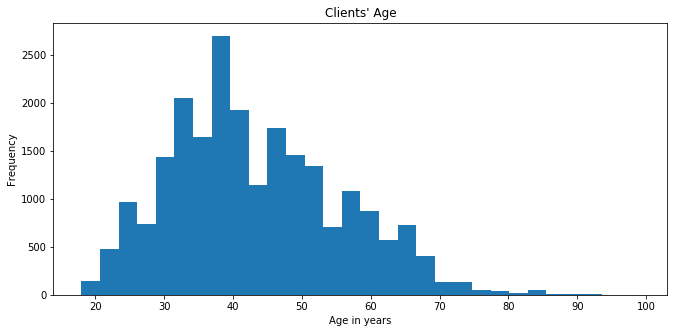

In [20]:
# Plotting histogram to show the distribution of age
plt.figure(figsize = (11,5))
plt.hist(new_data["age"],bins=30)
plt.xlabel("Age in years")
plt.ylabel("Frequency")
plt.title("Clients' Age")
plt.show();

#### 3.2. Looking Title column

In [21]:
new_data['title'].describe()

count     22628
unique    13984
top        Null
freq       2966
Name: title, dtype: object

In [22]:
new_data['title'].value_counts()

Null                                      2966
Love it!                                   136
Beautiful                                   95
Love                                        88
Love!                                       83
Beautiful!                                  72
Beautiful dress                             60
Love it                                     59
Love this dress!                            53
Gorgeous                                    53
Cute top                                    52
Disappointed                                51
Perfect                                     49
Great dress                                 49
Super cute                                  44
Adorable                                    43
Great top                                   42
Not for me                                  37
Runs small                                  36
Great dress!                                35
Disappointing                               35
Great top!   

The output above shows the frequency for each unique title on the dataset. We know that the majority of review text does not have a title as we can see a total of 2,966 without title, however, the second-highest frequency is the text reviews with the title "Love it!", which shows the positive experience from the customers.

#### 3.2.1. Generating WordCloud

WordCloud is a good tool to visualize the frequency or importance of each word that is shown in the Title column. It is possible to see the positive experience from customers when we read, for example, the words 'love', 'beautiful', 'cute' and 'perfect lovely'. Also, we can have the confirmation that 'top' and 'dress' are the products with the highest received reviews.

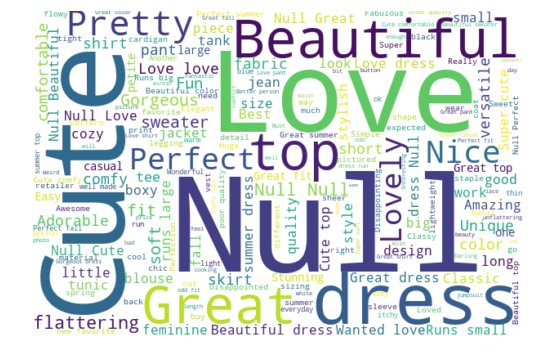

In [23]:
# Using wordcloud for title column
title = new_data['title'].str.cat(sep=' ')

# Creating and generating a wordcloud image
wordcloud = WordCloud(max_words=200, background_color='white', width=600, height=400, margin=0).generate(title)

# Displaying the image
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 3.3. Looking amount of Rating column

In [24]:
new_data['rating'].describe()

count    22628.000000
mean         4.183092
std          1.115911
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

In [25]:
# Getting value count for the 'rating' column
display(new_data['rating'].value_counts())

5    12527
4     4908
3     2823
2     1549
1      821
Name: rating, dtype: int64

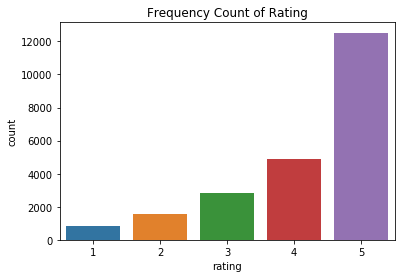

In [26]:
sns.countplot(x='rating', data=new_data)
plt.title('Frequency Count of Rating')
plt.show()

It is possible to observe that the highest number for the product score granted by the customer is 5, which means "Best" for the rating and represents around 55% of the total.

#### 3.4. Looking amount of Recommended IND column

In [27]:
new_data['recommended_ind'].describe()

count    22628.000000
mean         0.818764
std          0.385222
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: recommended_ind, dtype: float64

In [28]:
# Getting value count for the 'recommended_ind' column
display(new_data['recommended_ind'].value_counts())

1    18527
0     4101
Name: recommended_ind, dtype: int64

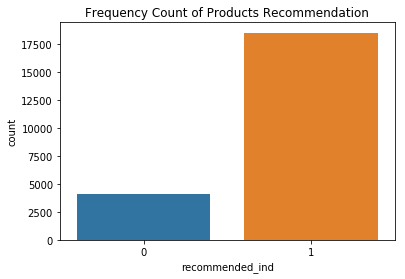

In [29]:
# Plotting countplot to show the distribution of products recommended
sns.countplot(x='recommended_ind', data=new_data)
plt.title('Frequency Count of Products Recommendation')
plt.show()

Considering the plot above, it is possible to see that there are 22,628 products.  It also shows that 18,527 products are recommended by customers and 4,101 products are not recommended, which represents around 82% and 18%, respectively. This data has a significant number of products that are recommended by customers.

#### 3.5. Looking amount of Positive Feedback Count column

In [30]:
new_data['positive_feedback_count'].describe()

count    22628.000000
mean         2.631784
std          5.787520
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        122.000000
Name: positive_feedback_count, dtype: float64

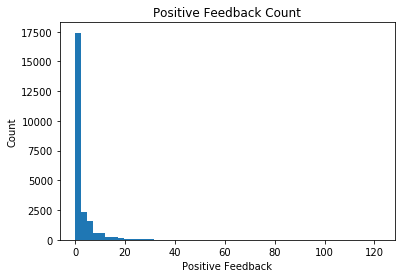

In [31]:
# Plotting histogram to show the distribution of positive feedback count

plt.hist(data["Positive Feedback Count"],bins=50)
plt.xlabel("Positive Feedback")
plt.ylabel("Count")
plt.title("Positive Feedback Count")
plt.show();

Considering the previous results, we can see the distribuitions from other customers who found the review positive.

#### 3.6. Looking some categorical columns

In [32]:
new_data[['division_name', 'department_name', 'class_name']].describe()

,division_name,department_name,class_name
count,22628,22628,22628
unique,3,6,20
top,General,Tops,Dresses
freq,13365,10048,6145


##### 3.6.1. Division name column

This column represents the categorical name of the product considering its high level division.

In [33]:
new_data['division_name'].describe()

count       22628
unique          3
top       General
freq        13365
Name: division_name, dtype: object

In [34]:
# Getting value count for the 'division_name' column
new_data['division_name'].value_counts()

General           13365
General Petite     7837
Initmates          1426
Name: division_name, dtype: int64

It is possible to see that there are three division levels, however, there is one division name that shows the wrong word spelling, so I decided to replace it for the right spelling 'Intimates'.

In [35]:
# Replacing all values of 'Initmates' with 'Intimates'
new_data.replace('Initmates', 'Intimates', inplace=True)

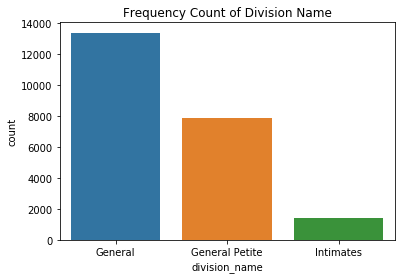

In [36]:
# Plotting countplot to show the distribution of division name
sns.countplot(x='division_name', 
              data=new_data, 
              order=new_data['division_name'].value_counts().index)
plt.title('Frequency Count of Division Name')
plt.show()

Considering the plot above, it is possible to see that the most frequency of products reviewed is in the General division level which represents around 59% of the total.

##### 3.6.2. Department name column

In [37]:
new_data['department_name'].describe()

count     22628
unique        6
top        Tops
freq      10048
Name: department_name, dtype: object

In [38]:
# Getting value count for the 'department_name' column
new_data['department_name'].value_counts()

Tops        10048
Dresses      6145
Bottoms      3662
Intimate     1653
Jackets      1002
Trend         118
Name: department_name, dtype: int64

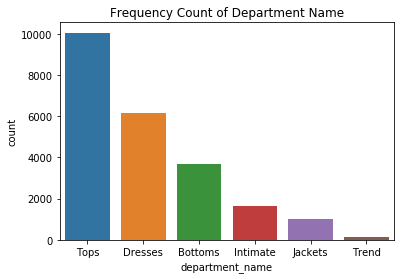

In [39]:
# Plotting countplot to show the distribution of department name
sns.countplot(x='department_name', 
              data=new_data, 
              order=new_data['department_name'].value_counts().index)
plt.title('Frequency Count of Department Name')
plt.show()

Considering the plot above, it is possible to observe that *Tops* and *Dresses* are the products that have the most reviews which represent around 71% of the total.

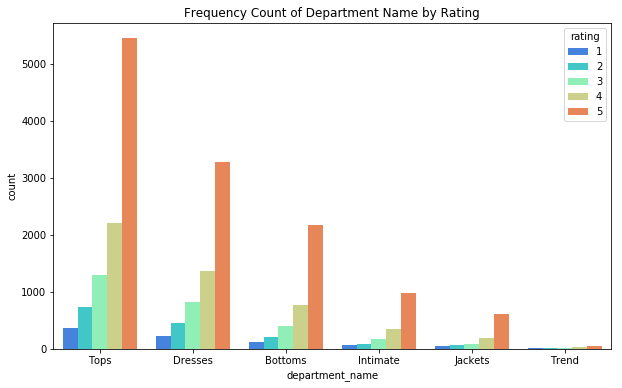

In [40]:
# Plotting histogram to show the distribution of department name by rating
plt.figure(figsize=(10,6))
ax = sns.countplot(x='department_name', 
                   hue='rating', 
                   data=new_data, 
                   palette='rainbow', 
                   order=new_data['department_name'].value_counts().index)
plt.title('Frequency Count of Department Name by Rating')
plt.show()

Moreover, considering the plot above by *Rating*, it is possible to se the distribuition for each categorie by rating.

##### 3.6.3. Class name column

In [41]:
new_data['class_name'].describe()

count       22628
unique         20
top       Dresses
freq         6145
Name: class_name, dtype: object

In [42]:
# Getting value count for the 'class_name' column
new_data['class_name'].value_counts()

Dresses           6145
Knits             4626
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1104
Fine gauge        1059
Skirts             903
Jackets            683
Lounge             669
Swim               332
Outerwear          319
Shorts             304
Sleep              214
Legwear            158
Intimates          147
Layering           132
Trend              118
Casual bottoms       1
Chemises             1
Name: class_name, dtype: int64

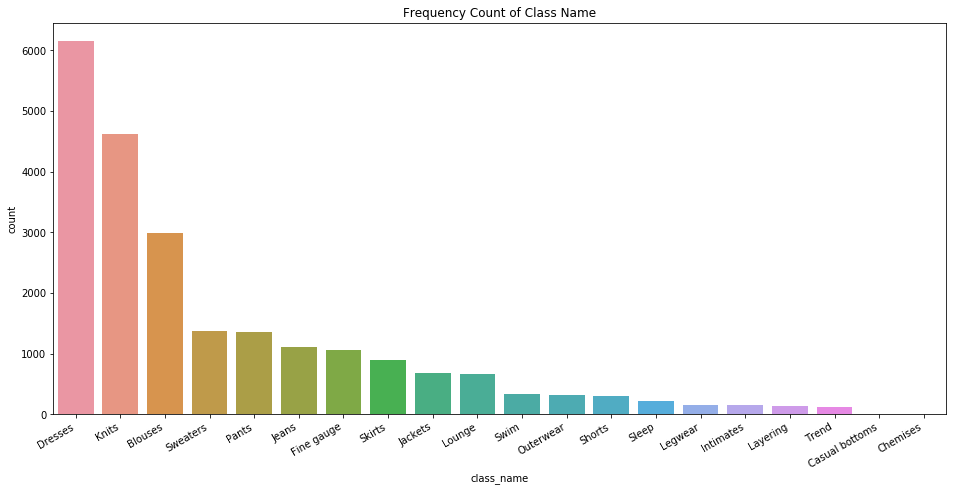

In [43]:
# Plotting countplot to show the distribution of class name
fig = plt.figure(figsize=(16,8))
sns.countplot(x='class_name', 
              data=new_data, 
              order=new_data['class_name'].value_counts().index)
fig.autofmt_xdate()
plt.title('Frequency Count of Class Name')
plt.show()

Considering the previous plot, we can see that *Dresses, Knits and Blouses* are the clothes that present most of the reviews. On the other hand, the clothes least represented are *Casual bottoms and Chemises*, just with 1 review each. 

### Step 4: Using get dummies for categorical features

In [44]:
new_data.columns

Index(['clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'division_name',
       'department_name', 'class_name'],
      dtype='object')

In [45]:
# Deciding which categorical features to use in model

for col_name in new_data.columns:
    if new_data[col_name].dtypes == 'object':
        unique = len(new_data[col_name].unique())
        print("Feature '{col_name}' has {unique} unique categories.".format(col_name=col_name, unique=unique))

Feature 'title' has 13984 unique categories.
Feature 'review_text' has 22621 unique categories.
Feature 'division_name' has 3 unique categories.
Feature 'department_name' has 6 unique categories.
Feature 'class_name' has 20 unique categories.


As we know, models can handle only numerical values. Considering the previous results, it is possible to see that for most of the features there are a lot of unique categories. In this case, it is not recommended to use dummies because it will increase the size of the data for categories that have few observations and can impact the results of the model. So, I decided to convert to numeric values the features 'division_name' and 'department_name'.

In [46]:
# Creating a list of features to dummy
dummy_list = ['division_name', 'department_name']

In [47]:
# Using function to dummy two categorical variables
def dummy_data(new_data, dummy_list):
    for x in dummy_list:
        dummies = pd.get_dummies(new_data[x], prefix=x, dummy_na=False)
        new_data = new_data.drop(x,1)
        new_data = pd.concat([new_data, dummies], axis=1)
    return new_data

In [48]:
clean_data = dummy_data(new_data, dummy_list)

In [49]:
clean_data.head()

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,class_name,division_name_General,division_name_General Petite,division_name_Intimates,department_name_Bottoms,department_name_Dresses,department_name_Intimate,department_name_Jackets,department_name_Tops,department_name_Trend
0,767,33,Null,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimates,0,0,1,0,0,1,0,0,0
1,1080,34,Null,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,1,0,0,0,1,0,0,0,0
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,1,0,0,0,1,0,0,0,0
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Pants,0,1,0,1,0,0,0,0,0
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Blouses,1,0,0,0,0,0,0,1,0


In [50]:
clean_data.shape

(22628, 17)

Considering the shape of the dataset, after the process applied to get dummies over two categorical columns we can see that the number of features jumps from 10 to 17 in total.

### Step 5: Basic text preprocessing

##### 5.1. Review text column

In [51]:
clean_data['review_text'].describe()

count                                                 22628
unique                                                22621
top       Perfect fit and i've gotten so many compliment...
freq                                                      3
Name: review_text, dtype: object

The output below is showing six samples of the review text and the score for this review as well.

In [52]:
print(clean_data[['review_text', 'rating']].sample(6).values)

[["Like everyone else, i ignored this vest in the store. my mom actually gave it to me to try on and practically forced me to buy it. it wasn't until  i got home that i discovered its versatility. i got it in the beginning of june so haven't been able to wear it much, but fall is quickly approaching and i already have at least ten outfits to wear with it. it's classy and can dress up any outfit."
  5]
 ['Wanted a cooler weather casual weekend errand dress and this is very confortable to wear with artistic leggings and tall boots. pockets are always handy and it is easy to style with a contrast scarf or long necklace. for added warmth can add a full slip or wear alone in spring with sandals. received numerous compliments wearing the first time, so purchased the navy one several weeks later. anticipate wearing these dresses often and when the cotton finally wears down will use as a nightgown. love'
  5]
 ["I am so sad that this romper didn't work out. it's just way too billowy and huge. 

In [53]:
clean_data[['review_text', 'rating']].groupby('rating').describe()

review_text                                                            \
             count unique                                                top   
rating                                                                         
1              821    821  This shirt looked cute until i tried it on... ...   
2             1549   1548  I purchased this and another eva franco dress ...   
3             2823   2823  This dress arrived with a black rope belt and ...   
4             4908   4908  Normally a 28, and on a fluke i dragged the 27...   
5            12527  12521  Perfect fit and i've gotten so many compliment...   

             
       freq  
rating       
1         1  
2         2  
3         1  
4         1  
5         3

The output above is showing the description of text reviews by rating. It is possible to see that most of the reviews are unique as they appear only once in the dataset and only 5 text reviews showed more than once at the dataset. 

##### 5.1.1. Generating WordCloud

WordCloud is a good tool to visualize the frequency or importance of each word that is shown in the Review Text column. 

It is possible to see the positive experience from customers when we read, for example, the words 'love', 'nice' and 'really perfect'. Also, we can have the confirmation that 'top' and 'dress' are the products with the highest received reviews.

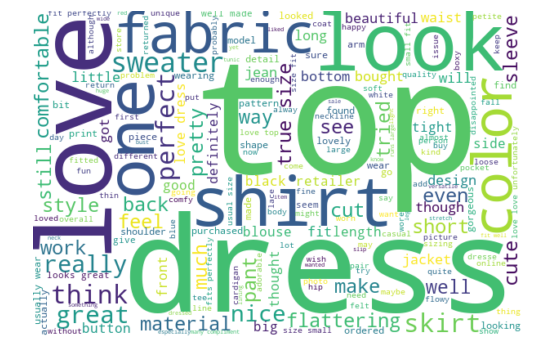

In [54]:
# Using wordcloud for review text column
text = clean_data['review_text'].str.cat(sep=' ')

# Creating and generating a wordcloud image
wordcloud = WordCloud(max_words=200, background_color='white', width=600, height=400, margin=0).generate(text)

# Displaying the image
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### 5.1.2. Converting into Lower case

In this first section, I will transform all the content of the review text into lower case. It is a good approach to avoid several copies of the same words. We can see how the text looks like after applying the lower case code below.

In [56]:
clean_data['lower_review'] = clean_data['review_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
clean_data['lower_review'].head()

0    absolutely wonderful - silky and sexy and comf...
1    love this dress! it's sooo pretty. i happened ...
2    i had such high hopes for this dress and reall...
3    i love, love, love this jumpsuit. it's fun, fl...
4    this shirt is very flattering to all due to th...
Name: lower_review, dtype: object

##### 5.1.3. Removing Stopwords and Punctuation

In [57]:
# Preparing to remove punctuation and stopwords
punctuations = string.punctuation
stop_words = set(stopwords.words('english'))

For this second section, I will remove all the punctuation and stopwords from the review text using predefined libraries found at nltk. This approach will be helpful to decrease the size of the dataset to modelling.

But before removing the stopwords from the data, I will calculate the number of stopwords, because it will permit extra information to identify how much we might have been losing before.

In [58]:
stopw_data = pd.DataFrame(clean_data['lower_review'])

In [59]:
stopw_data['stopwords_before'] = stopw_data['lower_review'].apply(lambda s: len([s for s in s.split() if s in stop_words]))
stopw_data[['lower_review','stopwords_before']].head()

,lower_review,stopwords_before
0,absolutely wonderful - silky and sexy and comf...,2
1,love this dress! it's sooo pretty. i happened ...,30
2,i had such high hopes for this dress and reall...,46
3,"i love, love, love this jumpsuit. it's fun, fl...",7
4,this shirt is very flattering to all due to th...,20


In [60]:
# Getting the total of stop_words 
Total = stopw_data['stopwords_before'].sum()
print (Total)

673161


Considering the previous output, it is good to know the total of the stopwords before applying the function.

I will define a function to remove all punctuation, stopwords and finally returns a string of the cleaned text review, as we can see below. 

In [61]:
def text_clean(review):
    """ 
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a string of the cleaned text review
    """
    texts = []
    
    # Checking the characters to see if there are any kind of punctuation
    no_punc = [char for char in review if char not in punctuations]

    # Joining the characters again to form the string
    no_punc = ''.join(no_punc)
    
    # Removing any stopwords
    tokens = [word for word in no_punc.split() if word.lower() not in stop_words]
    
    tokens1 = ' '.join(tokens)
    
    texts.append(tokens1)
    return pd.Series(texts)

### Step 6: Train - test split

As mentioned before, the problem that I am going to be tackling is to predict the scores of women's clothes based on text reviews. 

Firstly, I am not going to use all the features. After getting the results I can work on it and then start to consider feature selection for evaluating the models.

In [62]:
clean_data.head(2)

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,class_name,division_name_General,division_name_General Petite,division_name_Intimates,department_name_Bottoms,department_name_Dresses,department_name_Intimate,department_name_Jackets,department_name_Tops,department_name_Trend,lower_review
0,767,33,Null,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimates,0,0,1,0,0,1,0,0,0,absolutely wonderful - silky and sexy and comf...
1,1080,34,Null,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,1,0,0,0,1,0,0,0,0,love this dress! it's sooo pretty. i happened ...


In [63]:
df = pd.DataFrame(clean_data[['lower_review', 'rating']])

In [64]:
df.head()

,lower_review,rating
0,absolutely wonderful - silky and sexy and comf...,4
1,love this dress! it's sooo pretty. i happened ...,5
2,i had such high hopes for this dress and reall...,3
3,"i love, love, love this jumpsuit. it's fun, fl...",5
4,this shirt is very flattering to all due to th...,5


In [65]:
# Applying the function 'text_clean'
df['clean_review'] = df['lower_review'].apply(text_clean)

In [66]:
df.head()

,lower_review,rating,clean_review
0,absolutely wonderful - silky and sexy and comf...,4,absolutely wonderful silky sexy comfortable
1,love this dress! it's sooo pretty. i happened ...,5,love dress sooo pretty happened find store im ...
2,i had such high hopes for this dress and reall...,3,high hopes dress really wanted work initially ...
3,"i love, love, love this jumpsuit. it's fun, fl...",5,love love love jumpsuit fun flirty fabulous ev...
4,this shirt is very flattering to all due to th...,5,shirt flattering due adjustable front tie perf...


In [67]:
# Seperating the dataset into X and y for prediction
X = df['clean_review']
y = df['rating']

In [68]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (22628,)
y shape: (22628,)


In [69]:
# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [70]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18102,)
y_train shape: (18102,)
X_test shape: (4526,)
y_test shape: (4526,)


### Step 7: Converting Text to Numbers 

As we know, machines, as opposed to humans, and do not understand the raw text. 

Therefore, to proceed with this project I need to convert the text into numbers. Various approaches convert text into the corresponding numerical form. For this project, I will use Bag of Words.

#### 7.1. Bag of Words

In [74]:
# Creating CountVectorizer object
count_vect = CountVectorizer()

In [75]:
X_train_bow = count_vect.fit_transform(X_train)
X_train_bow = X_train_bow.toarray()

In [76]:
X_train_bow.shape

(18102, 17051)

In [77]:
X_test_bow = count_vect.transform(X_test).toarray()

In [78]:
X_test_bow.shape

(4526, 17051)

In [79]:
type(X_train_bow)

numpy.ndarray

In [80]:
type(X_test_bow)

numpy.ndarray

#### 7.1.1. Finding Term Frequency - Inverse Document Frequency (TF-IDF)

I will transform the X_train_bow that was created as bag-of-words into TF-IDF below.

In [81]:
# Creating TfidfTransformer object
tfidf_transformer = TfidfTransformer()

In [82]:
X_train_tfidf = tfidf_transformer.fit_transform(X_train_bow)
X_train_tfidf = X_train_tfidf.toarray()

In [83]:
X_train_tfidf.shape

(18102, 17051)

In [84]:
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [85]:
X_test_tfidf = tfidf_transformer.transform(X_test_bow).toarray()

In [86]:
X_test_tfidf.shape

(4526, 17051)

In [87]:
X_test_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Step 8: Fitting Linear Regression model

After all the process shown above, we have the text reviews represented as vectors, so we can train the regression problem to predict the rating. 

I'll be using scikit-learn here, choosing the Linear Regression to start with.

In [88]:
lm_tfidf = LinearRegression()

In [89]:
# Fitting linear regression model into the training data
lm_tfidf.fit(X_train_tfidf, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [90]:
#The bias term
bias_tfidf = lm_tfidf.intercept_

#The coefficient, notice it returns an array with one spot for each feature
coefficient_tfidf = lm_tfidf.coef_[0] 

print('Bias:', bias_tfidf)
print('Coefficients:', coefficient_tfidf)

Bias: 3.928981229305636
Coefficients: 2.083512892576648


In [91]:
lm_tfidf.intercept_ # value of beta_0

3.928981229305636

In [92]:
lm_tfidf.coef_ # value of beta_1

array([ 2.08351289e+00, -1.19742940e+00,  4.34722861e-01, ...,
       -2.33509820e+13, -1.10697478e+13,  1.14238739e+13])

In [93]:
print("Score on train data model was fitted to:", lm_tfidf.score(X_train_tfidf, y_train))
print("Score on test data model was fitted to:", lm_tfidf.score(X_test_tfidf, y_test))

Score on train data model was fitted to: 0.821626730136805
Score on test data model was fitted to: -5.293842132604825e+25


In [94]:
# Evaluating the model
y_pred_train_tfidf = lm_tfidf.predict(X_train_tfidf)
y_pred_test_tfidf = lm_tfidf.predict(X_test_tfidf)

In [95]:
# Regression Evaluation Metrics
print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train_tfidf))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train_tfidf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_tfidf)))

MAE: 0.3526187669308382
MSE: 0.22203490900896689
RMSE: 0.4712058032420302


In [96]:
# Regression Evaluation Metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test_tfidf))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test_tfidf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_tfidf)))

MAE: 2256636674713.957
MSE: 6.600894467516365e+25
RMSE: 8124588892686.426


The previous output shows that the MSE, one of the two evaluation metrics, is around 0.22 for train data and a value of 6.600894467516365e+25 for test data. On the other hand, the score is around 0.82 for train data and a small negative number for test data, which we can see that the model is not doing well.

### Step 9: Regularization of Linear Regression

I will now apply regularization to the previous Linear Regression model.

#### 9.1. Ridge Regression

For this project, I will use Ridge Regression where the loss function is modified to minimize the complexity of the model. 

Therefore, I need to tune the parameter called alpha. As we know, a low alpha value can lead to over-fitting, although a high alpha value can lead to under-fitting.

In [97]:
ridge_reg = Ridge(alpha = 0.01)
ridge_reg.fit(X_train_tfidf, y_train)

pred_train_ridge_reg = ridge_reg.predict(X_train_tfidf)

print(np.sqrt(mean_squared_error(y_train, pred_train_ridge_reg)))
print(r2_score(y_train, pred_train_ridge_reg))

pred_test_ridge_reg = ridge_reg.predict(X_test_tfidf)

print(np.sqrt(mean_squared_error(y_test,pred_test_ridge_reg))) 
print(r2_score(y_test, pred_test_ridge_reg))

0.39228574296508856
0.8763729341035184
1.0326981403220232
0.14470686438078995


In [98]:
ridge_reg = Ridge(alpha = 5)
ridge_reg.fit(X_train_tfidf, y_train)

pred_train_ridge_reg = ridge_reg.predict(X_train_tfidf)

print(np.sqrt(mean_squared_error(y_train, pred_train_ridge_reg)))
print(r2_score(y_train, pred_train_ridge_reg))

pred_test_ridge_reg = ridge_reg.predict(X_test_tfidf)

print(np.sqrt(mean_squared_error(y_test,pred_test_ridge_reg))) 
print(r2_score(y_test, pred_test_ridge_reg))

0.7195771424728874
0.5840288300922226
0.7848992537444788
0.5059214168090347


Considering the output above for alpha equal to 5, it is possible to see that the MSE and R-squared values for the Ridge Regression model on the training data is 0.71 and 58.40 percent, respectively. For the test data, the result for these metrics is 0.50 and 50.59 percent, respectively.

### Step 10: Comparing the results

Based on the previous results, the performance of the Linear Rregression and Ridge Regression models is summarized below:

1. Linear Regression Model: Test set MSE with a value of 6.600894467516365e+25 and R-square of -5.293842132604825e+25.

2. Ridge Regression Model: Test set MSE of 0.78 and R-square of 50.59 percent.

The Linear Regression model is performing the worst. Moreover, the Rigde Reegression model is performing better with values of R-squared.

### Step 11: Feature Selection

In [99]:
from sklearn import feature_selection

In [100]:
clean_data.head(3)

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,class_name,division_name_General,division_name_General Petite,division_name_Intimates,department_name_Bottoms,department_name_Dresses,department_name_Intimate,department_name_Jackets,department_name_Tops,department_name_Trend,lower_review
0,767,33,Null,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimates,0,0,1,0,0,1,0,0,0,absolutely wonderful - silky and sexy and comf...
1,1080,34,Null,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,1,0,0,0,1,0,0,0,0,love this dress! it's sooo pretty. i happened ...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,1,0,0,0,1,0,0,0,0,i had such high hopes for this dress and reall...


In [101]:
clean_data.columns

Index(['clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'class_name',
       'division_name_General', 'division_name_General Petite',
       'division_name_Intimates', 'department_name_Bottoms',
       'department_name_Dresses', 'department_name_Intimate',
       'department_name_Jackets', 'department_name_Tops',
       'department_name_Trend', 'lower_review'],
      dtype='object')

In [102]:
features_to_include = ['age','recommended_ind', 'positive_feedback_count', 'division_name_General', 
                       'division_name_General Petite','division_name_Intimates', 'department_name_Bottoms',
                       'department_name_Dresses', 'department_name_Intimate',
                       'department_name_Jackets', 'department_name_Tops','department_name_Trend']

In [103]:
feature_importances = feature_selection.mutual_info_regression(clean_data[features_to_include], clean_data['rating'])

In [104]:
feat_importance_df = pd.DataFrame(list(zip(features_to_include,feature_importances)), 
                                  columns=['feature','importance'])

In [105]:
feat_importance_df.sort_values(by='importance', ascending=False, inplace=True)

In [106]:
top_feats = [x for x in feat_importance_df['feature'][0:5]]
top_feats

['recommended_ind',
 'division_name_General Petite',
 'age',
 'department_name_Tops',
 'positive_feedback_count']

In [107]:
feature_importances

array([0.00383304, 0.32949616, 0.        , 0.        , 0.00538266,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00057067, 0.        ])

In [108]:
feat_importance_df

,feature,importance
1,recommended_ind,0.329496
4,division_name_General Petite,0.005383
0,age,0.003833
10,department_name_Tops,0.000571
2,positive_feedback_count,0.000000
3,division_name_General,0.000000
5,division_name_Intimates,0.000000
6,department_name_Bottoms,0.000000
7,department_name_Dresses,0.000000
8,department_name_Intimate,0.000000


#### 11.1. Fitting Linear Regression Model

In [109]:
linear_reg = LinearRegression()

In [110]:
regfit = linear_reg.fit(clean_data[top_feats], clean_data['rating'])

In [111]:
regfit.coef_

array([ 2.29337071e+00,  7.65501898e-03,  3.34202821e-04, -1.32217013e-02,
       -1.73456147e-03])

In [112]:
pd.DataFrame(list(zip(top_feats,regfit.coef_)), columns=['feature', 'coef'])

,feature,coef
0,recommended_ind,2.293371
1,division_name_General Petite,0.007655
2,age,0.000334
3,department_name_Tops,-0.013222
4,positive_feedback_count,-0.001735


In [113]:
regfit.score(clean_data[top_feats], clean_data['rating'])

0.6282554287728105

In [114]:
y_fit = regfit.predict(clean_data[top_feats])

In [115]:
r2_score(clean_data['rating'], y_fit)

0.6282554287728104

### Future approaches

Considering all the previous results, using the regularization for this preliminary project, I just could see a slight improvement.

Hence, I believe that some future approaches will provide better results and expand the goals for this project. Some of them are listed below:

- Analyze the importance of each feature: Try to understand the coefficients and the importance of the features for the model and the correlation that the features have with the target variable (direct or indirect) and see how the model will perform after this approach. I believe it is important to add features based on feature selection in the step 11 because there are relevant information connected with the target and would improve the final results.


- Cross-validation: Another technique that can also be tried along with feature selection techniques to improve the results as well.


- Trying some approaches for imbalanced data: As we can see, the dataset shows imbalanced classes for some features. So, I believe that it is important to apply two options to handle imbalanced classes. Even though it's important to consider that information could be lost, I believe that trying different techniques and comparing the final results could be another approach to take.


- Tuning the regularization parameter: In this case, I tuned alpha equal to 0.01 and equal to 5. So, it will be interesting to try other iterations to improve model performance. The best way to do it is altered by hyperparameter tuning to arrive at the optimal alpha value.